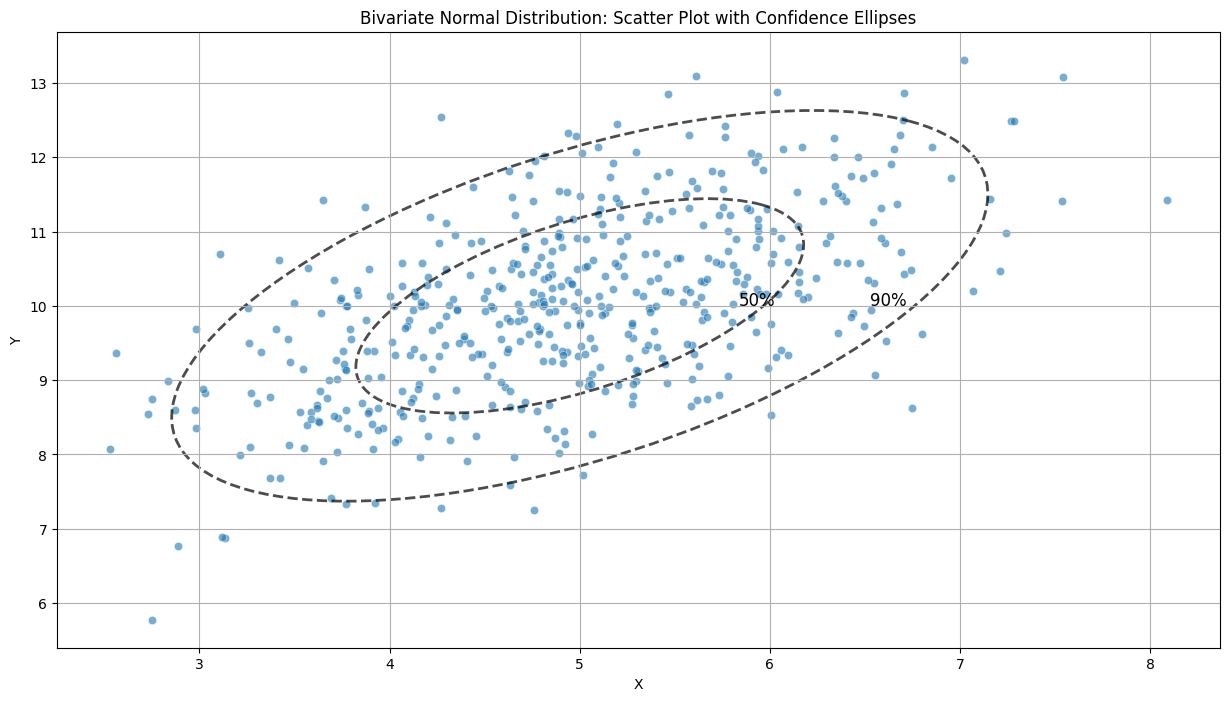

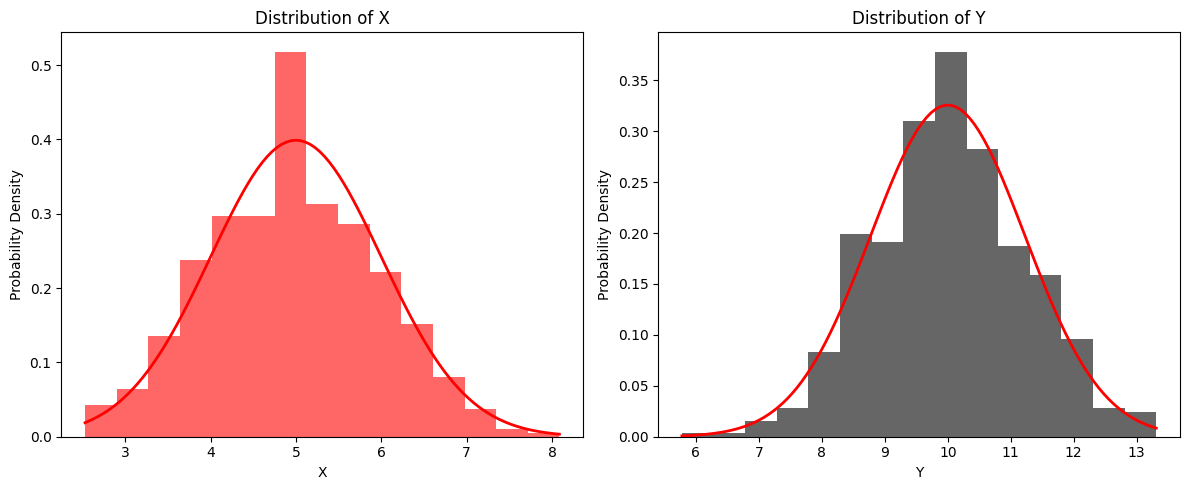

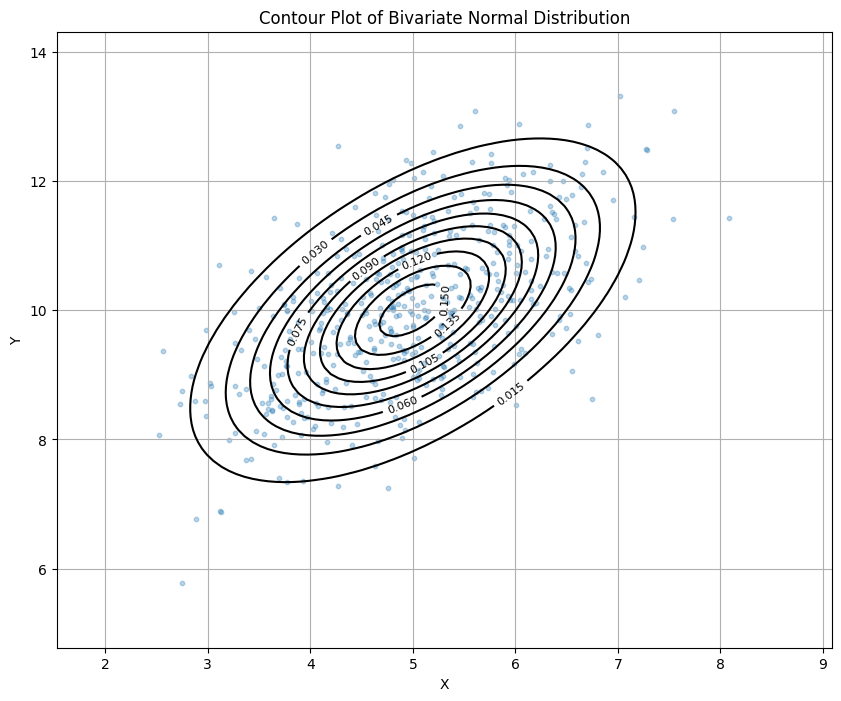

Chi-square statistic = 2.41
Critical value (α=0.05) = 5.99
p-value = 0.3004
Fail to reject normality hypothesis (χ² ≤ critical value)
Pearson correlation coefficient: r = 0.5664
95% confidence interval: [0.5037, 0.6231]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, chi2, norm
import seaborn as sns

# Distribution parameters
mean = [5, 10]  # Means
cov = [[1, 0.7], [0.7, 1.5]]  # Covariance matrix

# Generate sample
np.random.seed(32)
sample_size = 500
data = np.random.multivariate_normal(mean, cov, sample_size)
x = data[:, 0]
y = data[:, 1]

# Scatter plot with probability ellipses
plt.figure(figsize=(15, 8))
sns.scatterplot(x=x, y=y, alpha=0.6)

# Add confidence ellipses
for confidence in [0.5, 0.9]:
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(chi2.ppf(confidence, 2)) * np.sqrt(eigenvalues)

    ellipse = plt.matplotlib.patches.Ellipse(mean, width, height, angle=angle,
                                             fill=False, linestyle='--',
                                             linewidth=2, alpha=0.7)
    plt.gca().add_patch(ellipse)
    plt.text(mean[0] + width/2, mean[1], f'{int(confidence*100)}%', fontsize=12)

plt.title('Bivariate Normal Distribution: Scatter Plot with Confidence Ellipses')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Histograms for X and Y
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(x, bins=15, density=True, alpha=0.6, color='red')
x_range = np.linspace(min(x), max(x), 100)
ax1.plot(x_range, norm.pdf(x_range, mean[0], np.sqrt(cov[0][0])), 'r-', lw=2)
ax1.set_title('Distribution of X')
ax1.set_xlabel('X')
ax1.set_ylabel('Probability Density')

ax2.hist(y, bins=15, density=True, alpha=0.6, color='black')
y_range = np.linspace(min(y), max(y), 100)
ax2.plot(y_range, norm.pdf(y_range, mean[1], np.sqrt(cov[1][1])), 'r-', lw=2)
ax2.set_title('Distribution of Y')
ax2.set_xlabel('Y')
ax2.set_ylabel('Probability Density')

plt.tight_layout()
plt.show()

# Contour plot of the joint PDF
x_grid = np.linspace(min(x)-1, max(x)+1, 100)
y_grid = np.linspace(min(y)-1, max(y)+1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y))

rv = multivariate_normal(mean, cov)

plt.figure(figsize=(10, 8))
contour = plt.contour(X, Y, rv.pdf(pos), levels=10, colors='k')
plt.clabel(contour, inline=True, fontsize=8)
plt.scatter(x, y, alpha=0.3, s=10)
plt.title('Contour Plot of Bivariate Normal Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Chi-square test for normality in 2D bins
mu = np.mean(data, axis=0)
cov = np.cov(data, rowvar=False)
rv = multivariate_normal(mu, cov)

n_bins = 9
x_edges = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), int(np.sqrt(n_bins)) + 1)
y_edges = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), int(np.sqrt(n_bins)) + 1)

observed, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=[x_edges, y_edges])
observed = observed.flatten()

expected = []
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        x_low, x_high = x_edges[i], x_edges[i+1]
        y_low, y_high = y_edges[j], y_edges[j+1]
        prob = rv.cdf([x_high, y_high]) - rv.cdf([x_low, y_high]) - rv.cdf([x_high, y_low]) + rv.cdf([x_low, y_low])
        expected.append(prob * len(data))

expected = np.array(expected)
valid_bins = expected >= 5
observed = observed[valid_bins]
expected = expected[valid_bins]

chi2_stat = np.sum((observed - expected)**2 / expected)
dof = len(observed) - 1 - 5
p_value = 1 - chi2.cdf(chi2_stat, dof)
chi2_critical = chi2.ppf(0.95, dof)

print(f"Chi-square statistic = {chi2_stat:.2f}")
print(f"Critical value (α=0.05) = {chi2_critical:.2f}")
print(f"p-value = {p_value:.4f}")

if chi2_stat <= chi2_critical:
    print("Fail to reject normality hypothesis (χ² ≤ critical value)")
else:
    print("Reject normality hypothesis (χ² > critical value)")

# Pearson correlation coefficient and confidence interval
X = data[:, 0]
Y = data[:, 1]
n = len(X)

mean_X = np.mean(X)
mean_Y = np.mean(Y)
cov_XY = np.sum((X - mean_X) * (Y - mean_Y)) / n
sigma_X = np.sqrt(np.sum((X - mean_X)**2) / n)
sigma_Y = np.sqrt(np.sum((Y - mean_Y)**2) / n)
r = cov_XY / (sigma_X * sigma_Y)

z = np.arctanh(r)
SE_z = 1 / np.sqrt(n - 3)
z_lower = z - norm.ppf(0.975) * SE_z
z_upper = z + norm.ppf(0.975) * SE_z
r_lower = np.tanh(z_lower)
r_upper = np.tanh(z_upper)

print(f"Pearson correlation coefficient: r = {r:.4f}")
print(f"95% confidence interval: [{r_lower:.4f}, {r_upper:.4f}]")